In [1]:
# Load paths
path_to_features = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/diagnosis_ML4H.csv"  
path_to_date = f'/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/labels_ML4H.csv'
# Save paths
path_to_model = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/" 
path_to_figs = path_to_model + 'plots/'

import os
os.chdir('/rds/homes/g/gaddcz/Projects/mmVAE/src/')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from wrappers import fit_restarts
import helpers

torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline

# Load CPRD data
Here we load the CPRD data from outside the repository. 
We then re-order the the columns (which won't affect modelling) to  aid visualisation later. 
Finally we remove non-multimorbidity cases (with fewer than 2 conditions)

In [2]:
diag_frame = pd.read_csv(path_to_features)[helpers.get_column_order()]
diag_frame = diag_frame[diag_frame.sum(axis = 1) >= 2]
diag_frame.columns = helpers.get_column_order(plot=True)
diag_frame.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

N = diag_frame.shape[0]
D = diag_frame.shape[1]

# Check prevalence of diseases
print(list(zip(diag_frame.columns, diag_frame.to_numpy().sum(axis=0))))

print(f"\n We have {N} training samples, and {D} conditions")


[('Cancer', 2890), ('Asthma', 85395), ('Female infertility', 24125), ('Allergic Rhin Conj', 92404), ('Migraine', 64686), ('Anxiety', 97255), ('Depression', 133090), ('Substance misuse', 11638), ('Alcohol problem', 5683), ('Eating disorder', 11645), ('SMHmm', 11108), ('Other mental', 47124), ('Other headache', 23626), ('AdrenalAll', 62), ('Pituitary', 2010), ('PCOS', 21012), ('Sarcoid', 292), ('Leiomyoma', 3338), ('Endometriosis', 10507), ('Retinal detachment', 473), ('PTH', 134), ('Heart failure', 383), ('IHD/MI', 664), ('Stroke', 1010), ('Interstitial lung', 50), ('Blind', 118), ('COPD', 323), ('Solid organ transplant', 181), ('Bronchiectasis', 382), ('Neuro development', 2542), ('Atopic eczema', 16581), ('Cardiomyopathy', 207), ('Cystic fybrosis', 239), ('Sickle cell', 119), ('Pulminary Heart', 45), ('IBS', 49439), ('Turners syndrome', 57), ('Marfan syndrome', 125), ('HIV', 267), ('Diabetes', 5071), ('Diabetes (retino)', 1720), ('Hypertension', 6876), ('Spina bifida', 644), ('Congeni

# t-SNE visualisaton
The t-SNE visualisation on the full dataset. Whilst some separation can be seen, the correct clusters are hard to determine due to the complex underlying multimorbidity structure.

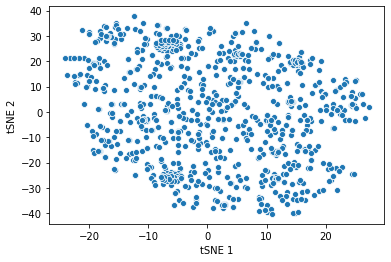

In [3]:
YtSNE = diag_frame.sample(n=1000, random_state=1, replace=False)
latentTSNE = TSNE(n_components=2, init='random').fit_transform(YtSNE)

tSNE = pd.DataFrame(latentTSNE, columns=['tSNE 1', 'tSNE 2'], index=YtSNE.index)
sns.scatterplot(data = tSNE, x = "tSNE 1", y = "tSNE 2");  
plt.show()

# Define model parameterisation and architecture

In [6]:
L = 16
architecture = {'enc_h': [D, D, D, L], 
                'dec_h': [L, D, D, D], 
                'constrain': ['L0', 'L0'],
               }
model_params = {'tmp_schedule': [4, 0.4, 0.4],
                 'epochs': 50,
                 'batch_size': 1024,
                 'lr': 5e-3,
                 'verbose': 0,
                 'anneal': True,
                }

# Run experiment

We train for multiple $\beta$ values, with multiple restarts. This is **not** due to local minima, but to analayse how clustering differs across seeds. As $\beta$ increases (and particularly when it is positive) this demonstrates how the clustering degrades.

Regardless, we take the seed with the smallest loss. However, smallest loss does not necessarily mean better clustering here.

Plot order
* the prevalence of each condition in each quantised cluster
* the odds ratio (truncated to have maximum value $5$) of each quantised cluster
* the cluster factor association matrix
* the prevalence within factors
* the odds ratio within factors


For demonstration, we consider multiple cases. 
* $\hat{\beta} = [-1, -0.4]$ 
* $\hat{\beta} = 0$ (auto-encoder with no entropy term attached)
* $\hat{\beta} = 0.1$ is the original positive formulation which maximises latent uncertainty (pushing latent values towards $0.5$).

Normalised beta=-1
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg1_00_0.pickle, training...
Final:
====> Train loss: 0.869 (Reconstruction loss:0.86317 and entropy:0.00128).
====> Validation loss: 0.838 (Reconstruction loss:0.83671 and entropy: 0.00021).
		====> Counts at epoch 49: 299 clusters, with 60 above 1000 patients
... saving to /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg1_00_0.pickle
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg1_00_1.pickle, training...
Final:
====> Train loss: 0.953 (Reconstruction loss:0.94527 and entropy:0.00158).
====> Validation loss: 0.933 (Reconstruction loss:0.92973 and entropy: 0.00066).
		====> Counts at epoch 49: 171 clusters, with 61 above 1000 patients
.

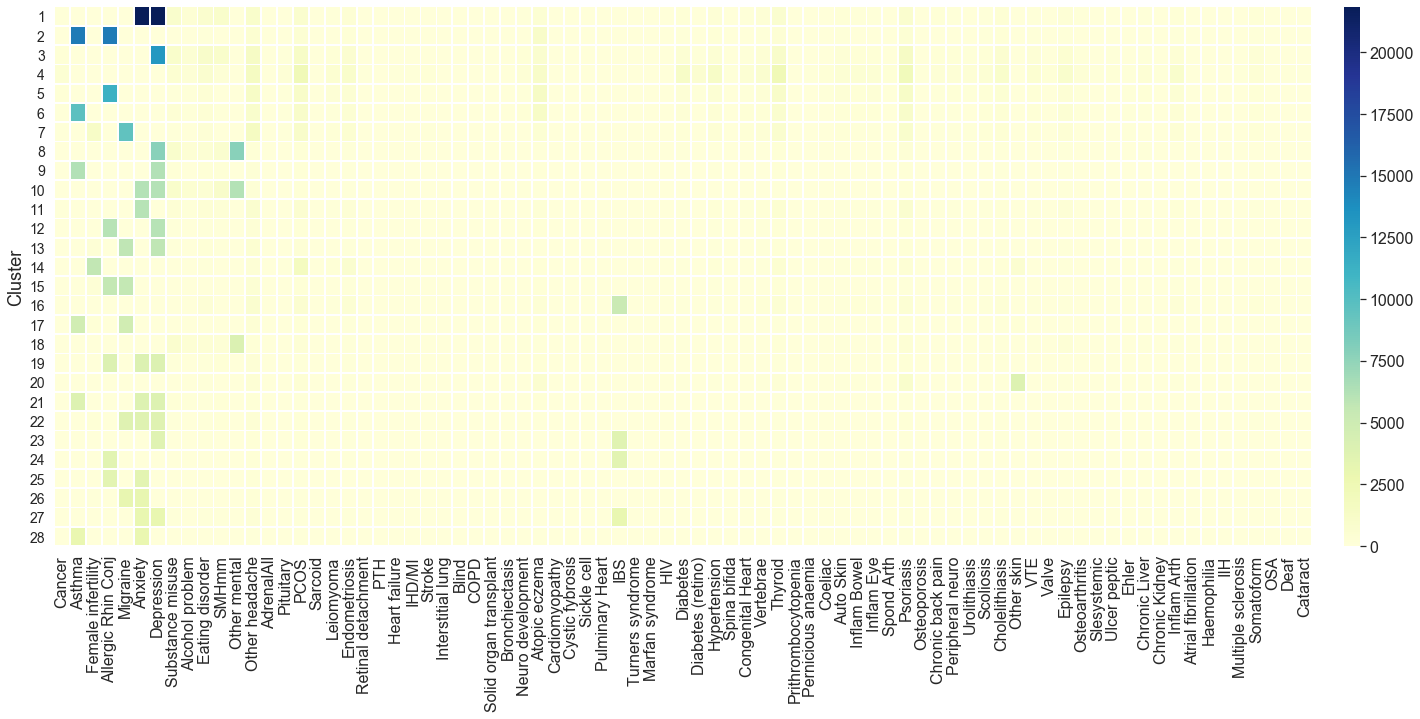

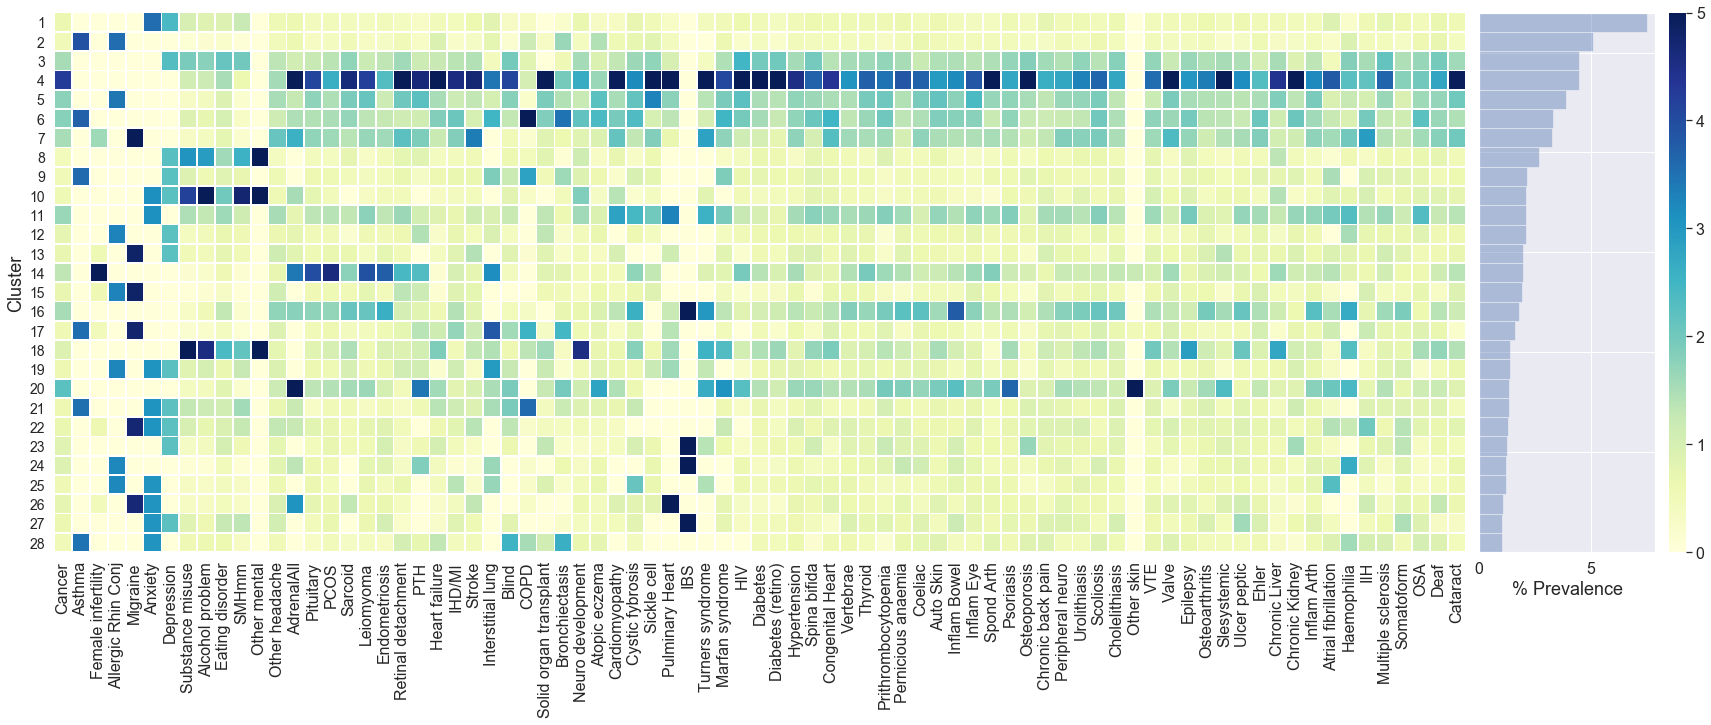

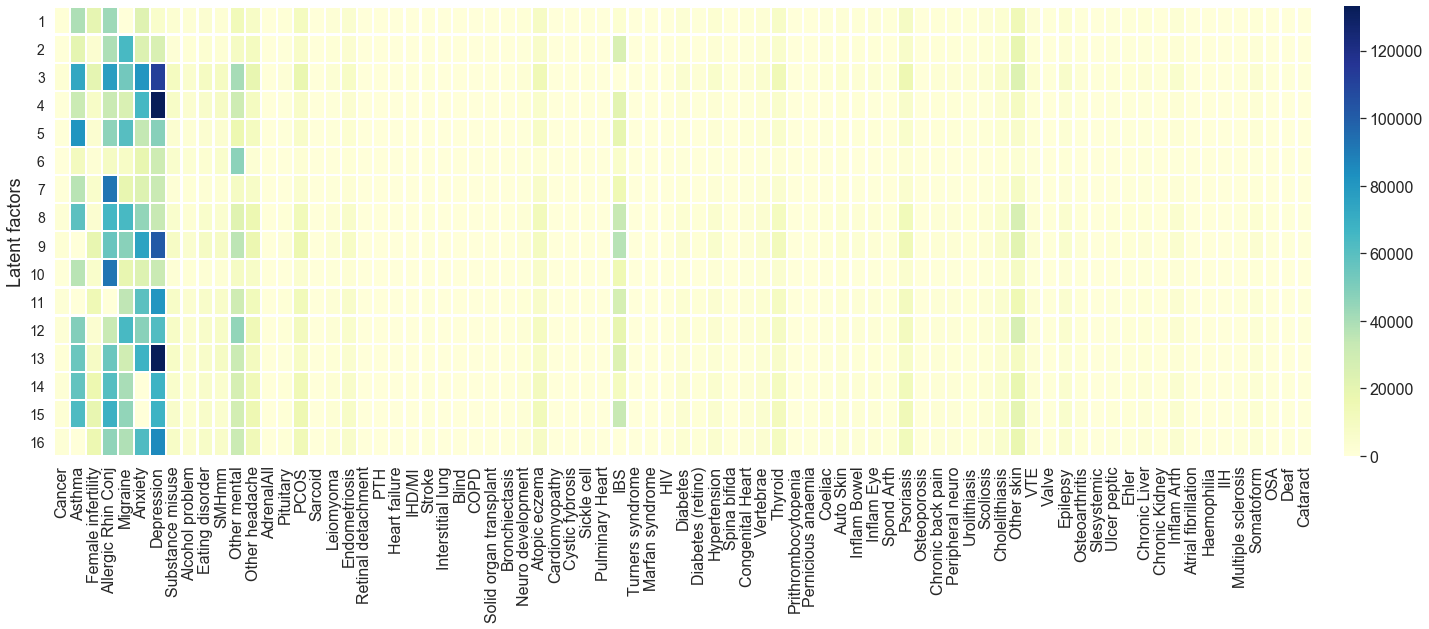

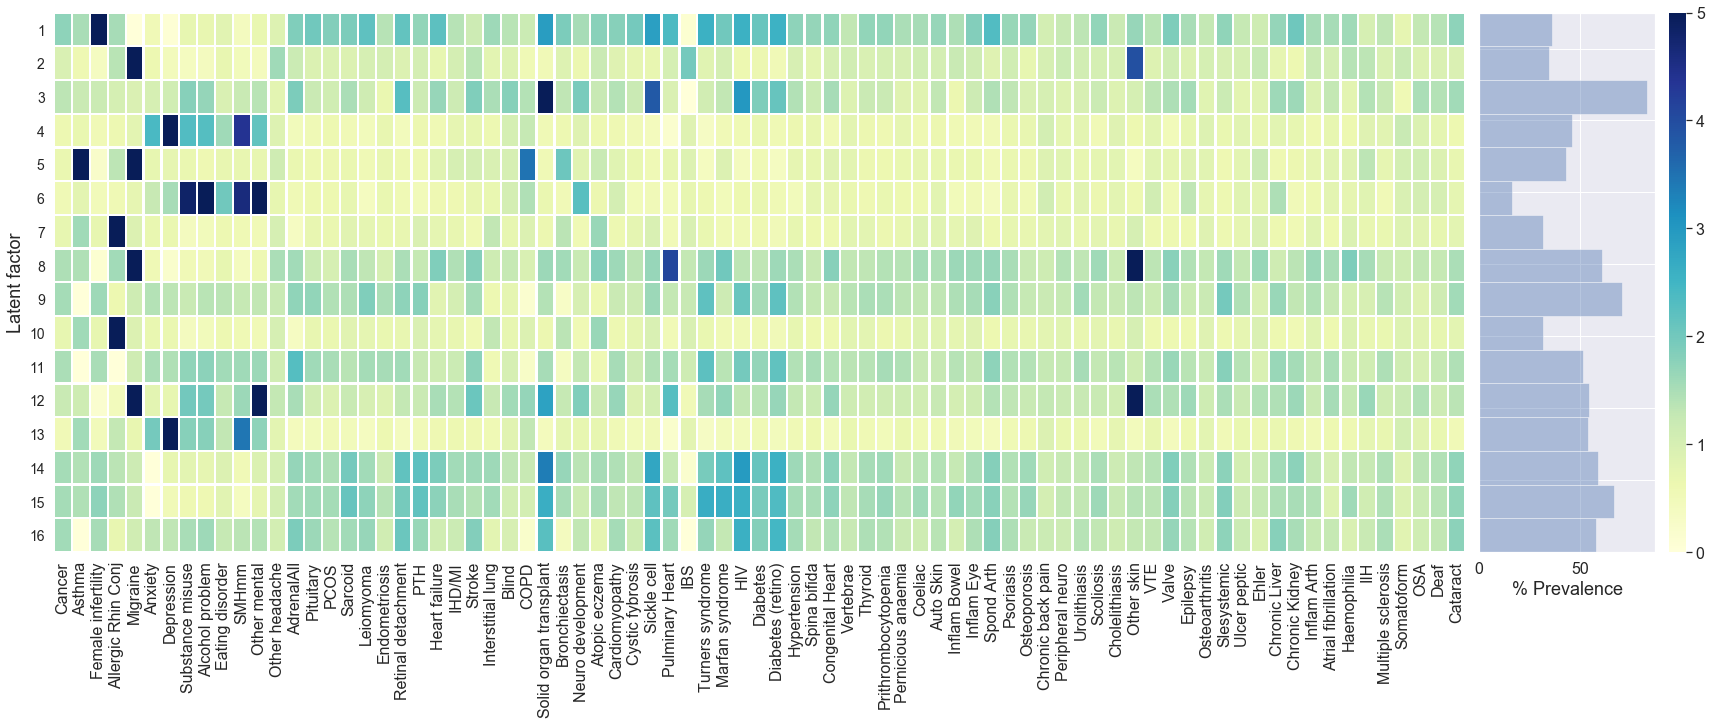

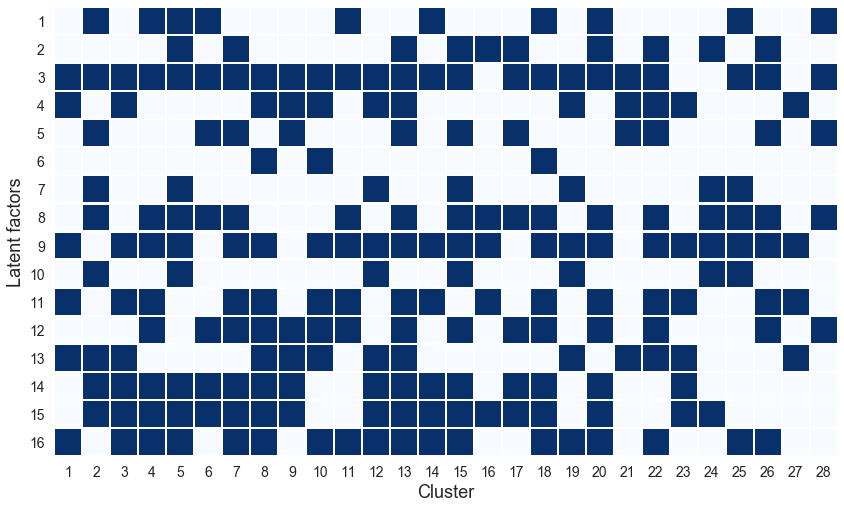

Saving best seed clustering for normalised beta -1 at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg1_00_0


Normalised beta=-0.4
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg0_40_0.pickle, training...
Final:
====> Train loss: 0.854 (Reconstruction loss:0.84857 and entropy:0.00299).
====> Validation loss: 0.877 (Reconstruction loss:0.86829 and entropy: 0.00437).
		====> Counts at epoch 49: 419 clusters, with 62 above 1000 patients
... saving to /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg0_40_0.pickle
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg0_40_1.pickle, training...
Final:
====> Train loss: 0.827 (Rec

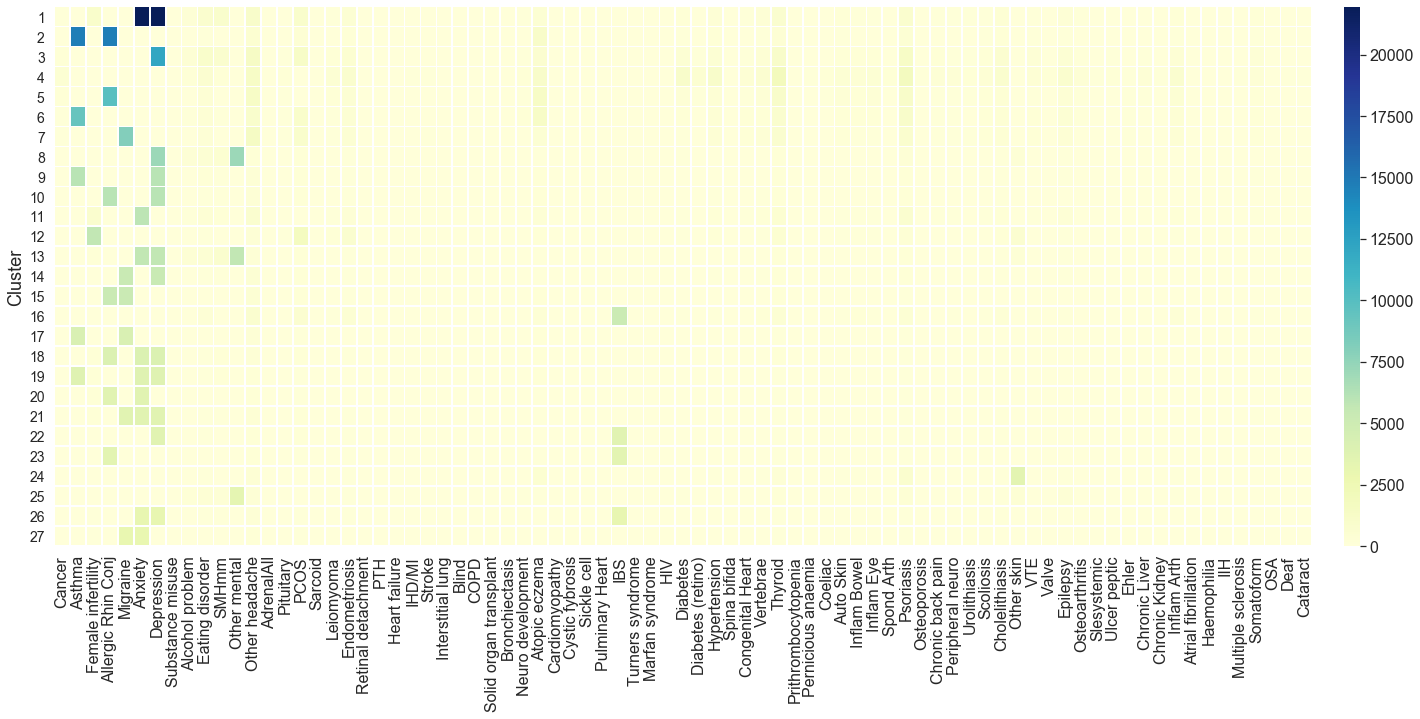

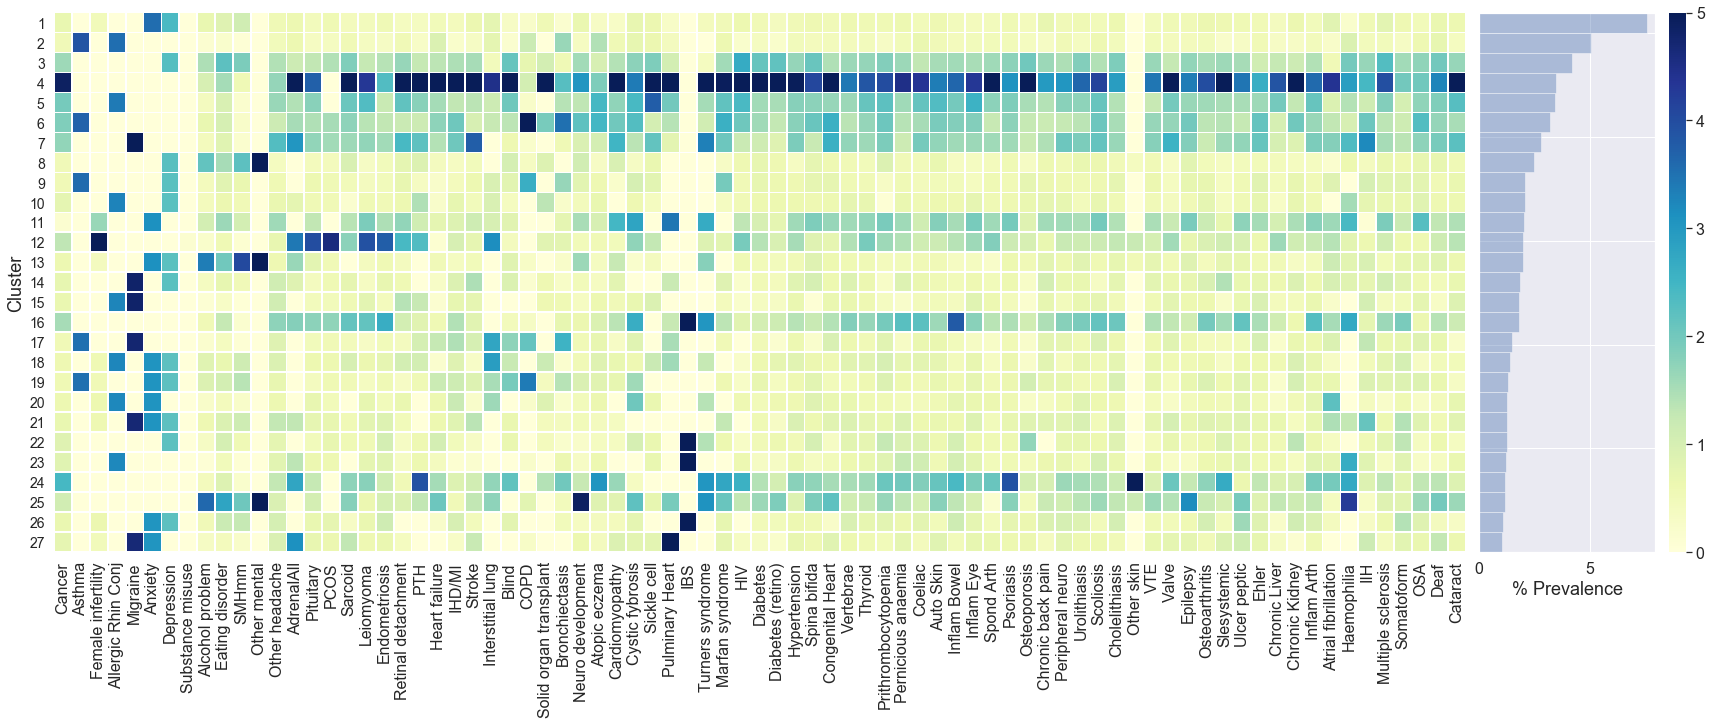

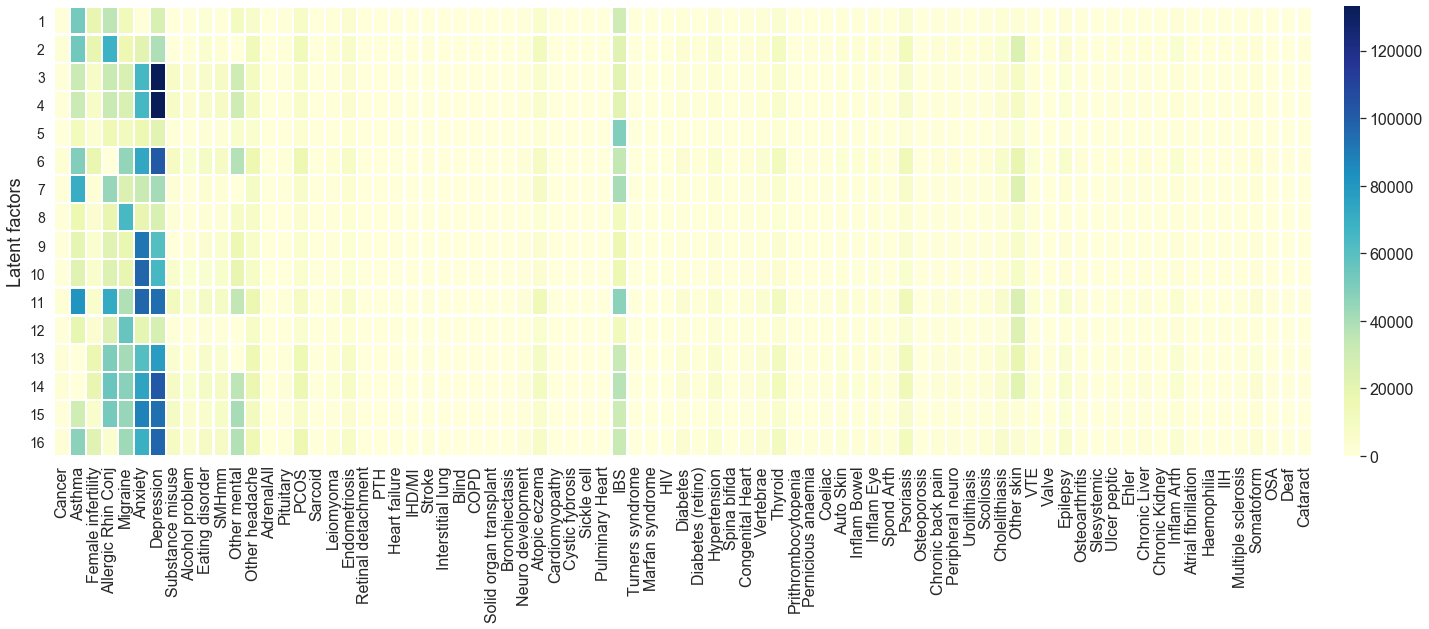

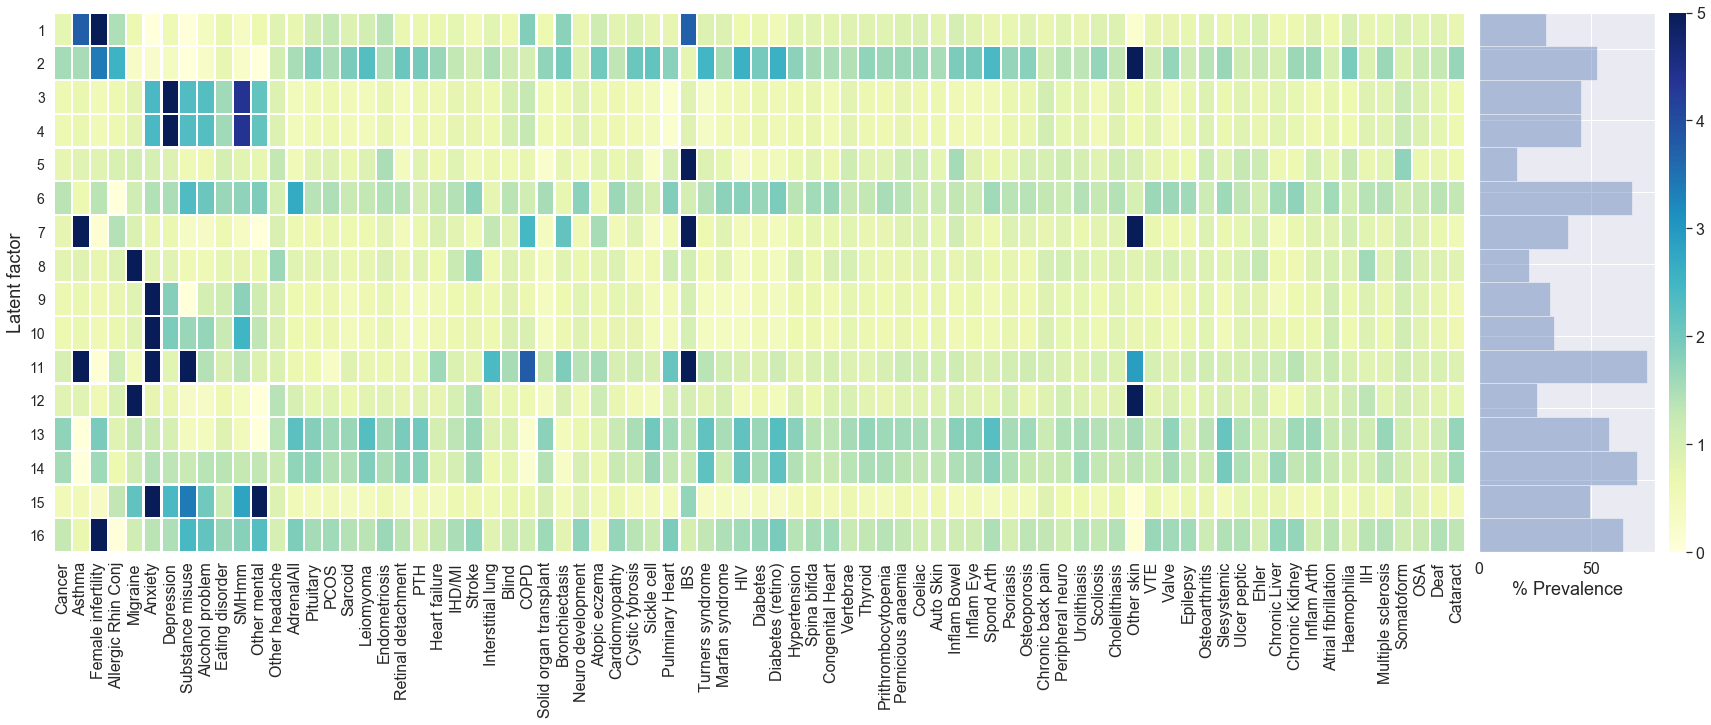

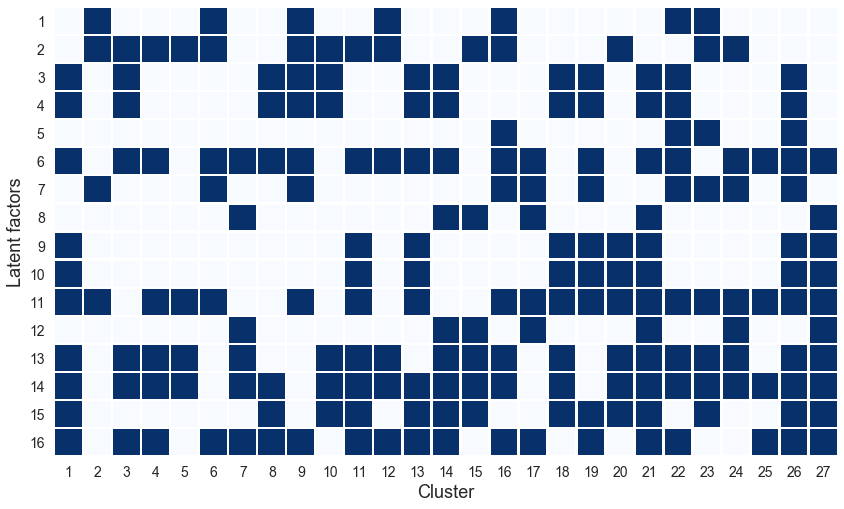

Saving best seed clustering for normalised beta -0.4 at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg0_40_1


Normalised beta=0
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_00_0.pickle, training...
Final:
====> Train loss: 0.323 (Reconstruction loss:0.32326 and entropy:0.07549).
====> Validation loss: 0.337 (Reconstruction loss:0.33650 and entropy: 0.09461).
		====> Counts at epoch 49: 8898 clusters, with 50 above 1000 patients
... saving to /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_00_0.pickle
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_00_1.pickle, training...
Final:
====> Train loss: 0.276 (Reconstructi

In [ ]:
norm_betas = [-1, -0.4, 0, 0.1]

dicts, avg_amis = [], []
for b in norm_betas:
    print(f"====================\nNormalised beta={b}\n====================")
    
    model_params['norm_beta'] = b
    method = f'Bernoulli_Beta{b:.2f}'.replace(".", "_").replace("-", "Neg")

    best_dict, best_path, avg_ami = fit_restarts(diag_frame, architecture, model_params,
                                                 n_restarts=3, plot_threshold_frac=0.01,
                                                 save_path=f"{path_to_model}{method}",
                                                 plot_path=f"{path_to_figs}{method}",
                                                 yaxis_scale=1.2,
                                                 force_retrain=True)
    
    print(f"Saving best seed clustering for normalised beta {b} at {best_path}\n\n")
    np.savetxt(best_path + "cluster_allocations.txt", best_dict['cluster_allocations'])
    np.savetxt(best_path + "factors.txt", best_dict['z_binary'])
    avg_amis.append(avg_ami)